In [1]:
import numpy as np
import random
import matplotlib.pyplot as plt

In [93]:
def ChooseModel(role_models, mu, theta, num_sims,num_gens,N,model):
    
    #running simulations based on model type
    if model == "OTM":
        
        original_rm = role_models
        
        #list to keep track of results for each innovation rate
        per_mu = {}
        for i in mu:
            per_rm = {}
            #for OTM, theta = 1, loop on each 0.1 proportion of role models from 0.1->1
            while (role_models*N) <= N:
                
                #list to keep track of results at each role model ratio
                
                
                #initialize ne,sdi,vars arrays per population, per generation
                final_ne = np.zeros([num_gens,2])
                final_sdi = np.zeros([num_gens,2])
                final_vars = np.zeros([num_gens, 2])
                
                
                #for each simulation, get the resulting ne,sdi,vars and add it to final arrays
                for n in range(num_sims):
                    sim_ne, sim_sdi, sim_vars = RunSimulation(num_gens,N,role_models,i,theta)
                    final_ne += sim_ne
                    final_sdi += sim_sdi
                    final_vars += sim_vars
                    
                #average out each array by the number of simulations to get mean values per gen
                final_ne = final_ne/num_sims
                final_sdi = final_sdi/num_sims
                final_vars = final_vars/num_sims
                
                #append a list of all three arrays in the role model list
                #to get the values at this current role model rate
                per_rm[str(role_models)] = [final_ne,final_sdi,final_vars]
                
                role_models += 0.1
            
            #finally, append the "per role model rate" list into the list for each mu value
            per_mu[str(i)] = per_rm
            role_models = original_rm
        
        #return this list for figure creation
        #contains the final,averaged arrays for ne,sdi,vars across all gens
        #across role model proportions
        return per_mu
    
    
    else:
        #for frequency dependent model,
        #role_models = 1 because the whole population can transmit cultural information
        #looping the same way as the previous except iterating per theta value instead
        #of role models
        per_mu = {}
        for i in mu:
            #keep track of results for each value of theta
            per_theta = {}
            for t in theta:
                #initialize ne,sdi,vars arrays per population, per generation
                final_ne = np.zeros([num_gens,2])
                final_sdi = np.zeros([num_gens,2])
                final_vars = np.zeros([num_gens, 2])
                for n in range(num_sims):
                    sim_ne,sim_sdi,sim_vars = RunSimulation(num_gens,N,role_models,i,t)
                    final_ne += sim_ne
                    final_sdi += sim_sdi
                    final_vars += sim_vars
                    
                #same pattern of averaging across generations per sim
                final_ne = final_ne/num_sims
                final_sdi = final_sdi/num_sims
                final_vars = final_vars/num_sims
                
                #only need final_ne for figures for frequency dependent
                per_theta[str(t)] = final_ne
            
            #append each theta result into per_mu array
            per_mu[str(i)] = per_theta
        
        #return this list for figure 3 creation
        #contains the final, averaged array for Ne across all gens
        #for each combination of theta and mu
        return per_mu
                

In [94]:
def RunSimulation(num_gens, pop_size, role_models, mu, theta):
    #set up each population as an array of N members
    pop = np.zeros([2,pop_size])
    
    pop, max_vars, sdi_a, sdi_b, tmp_pop = RunBurnIn(pop, pop_size, mu)
    
    #set up 2-D arrays for Ne, SDI, and number of unique variants for each pop
    #PER generation
    ne = np.zeros([num_gens, 2])
    sdi = np.zeros([num_gens,2])
    unique_vars = np.zeros([num_gens,2])
    
    #Calculate initial values for ne,sdi,vars after burn-in
    #first, ne...calculate the number of times each variant shows up
    #in the population, and set that as the number of offspring for 
    #that variant. Ne = (popsize -1) / variance of offspring produced
    #per variant
    
    numOffspring1 = np.zeros(pop_size)
    numOffspring2= np.zeros(pop_size)
    for i in range(pop_size):
        numOffspring1[i] = (len(np.where(tmp_pop[0] == i)[0]))
        numOffspring2[i] = (len(np.where(tmp_pop[1] == i)[0]))
    
    ne[0,0] = (pop_size-1) /(np.var(numOffspring1))
    ne[0,1] = (pop_size-1) /(np.var(numOffspring2))
    #next, sdi:
    sdi[0,0] = SDI(pop[0])
    sdi[0,1] = SDI(pop[1])
    
    #lastly, number of unique variants
    unique_vars[0,0] = len(np.unique(pop[0]))
    unique_vars[0,1] = len(np.unique(pop[1]))
    
    for gen in range(1, num_gens):
        cur_ne, cur_sdi, cur_vars, pop = RunGeneration(pop, pop_size, max_vars, theta, mu, role_models)
        ne[gen,0] = cur_ne[0]
        ne[gen,1] = cur_ne[1]
        
        sdi[gen,0] = cur_sdi[0]
        sdi[gen,1] = cur_sdi[1]
        
        unique_vars[gen,0] = cur_vars[0]
        unique_vars[gen,1] = cur_vars[1]
        
        max_vars[0] = pop[0].max()
        max_vars[1] = pop[1].max()
    return ne,sdi,unique_vars
    

In [95]:
def RunBurnIn(pop, pop_size, mu):
    
    pop[0] = np.random.choice(pop_size, pop_size, replace=False)
    pop[1] = np.array([1]*pop_size)
    
    max_vars = []
    max_vars.append(pop_size)
    max_vars.append(1)
    
    sdi_a = SDI(pop[0])
    sdi_b = SDI(pop[1])
    tmp_pop = np.zeros([2,pop_size])
    
    while sdi_a > sdi_b:
        tmp_pop = np.zeros([2,pop_size])
        
        for i in range(2):
            #perform cultural transmission
            tmp_pop[i] = np.random.choice(pop_size, pop_size, replace=True)
            rounded_tmp_pop = tmp_pop[i].astype(int)
            pop[i] = pop[i, rounded_tmp_pop]
            
            #undergo innovation
            new_innovators = np.random.binomial(1, mu, pop_size)
            pop[i,np.where(new_innovators==1)] = np.arange(max_vars[i]+1,max_vars[i]+len(np.where(new_innovators ==1))+1)
            max_vars[i] = pop[i].max()
            
        sdi_a = SDI(pop[0])
        sdi_b = SDI(pop[1])
    
    return pop, max_vars, sdi_a, sdi_b, tmp_pop

In [96]:
def RunGeneration(pop, pop_size, max_vars, theta, mu, role_models):
    ne = np.zeros(2)
    sdi = np.zeros(2)
    unique_vars = np.zeros(2)
    for i in range(2):
        #set of potential people to transmit new vars (only from role models)
        #If FreqDep, then each person has the potential of transmitting a variant
        new_vars = np.random.choice(pop_size,int(role_models*pop_size), replace=False)
        
        #getting the actual variants they have from the population
        variants = np.unique(pop[i,new_vars])
        
        #getting variant frequencies
        var_freq = np.zeros(len(variants))
        for j in range(len(variants)):
            var_freq[j] = len(np.where(pop[i,new_vars]== variants[j])[0])
        
        #getting the probability of individuals choosing each variant
        probs = np.power(var_freq,theta) / sum(np.power(var_freq,theta))
        probs_individual = probs/var_freq
        
        #assigning weights
        weights = np.zeros(len(new_vars))
        for v in range(len(new_vars)):
            weights[v] = probs_individual[np.where(variants == pop[i,new_vars[v]])]
        
        #getting new set of culturally transmitted individuals
        tmp = np.random.choice(new_vars, pop_size, replace=True, p=weights)
        
        pop[i] = pop[i,tmp]
        
        #computing ne, sdi, unique vars
        offspring = np.zeros(pop_size)
        for p in range(pop_size):
            offspring[p] = (len(np.where(tmp == p)[0]))
        ne[i] = (pop_size-1) / np.var(offspring)
        
        sdi[i] = SDI(pop[i])
        
        unique_vars[i] = len(np.unique(pop[i]))
        
        #add innovators
        new_innovators = np.random.binomial(1, mu, pop_size)
        pop[i,np.where(new_innovators==1)] = np.arange(max_vars[i]+1,max_vars[i]+len(np.where(new_innovators ==1))+1)
        max_vars[i] = pop[i].max()
        
    return ne,sdi,unique_vars,pop

In [97]:
def SDI(subPop):
    count = 0
    for i in np.unique(subPop):
        count += (len(np.where(subPop == i)[0])*len(np.where(subPop == i)[0]))
    return 1 - (count / (len(subPop)*len(subPop)))

In [ ]:
#Running OTM model
# Variables, parameters, initializations
num_simulations = 3
N = 1000 # true population size
num_gens = 100
num_pops = 2 # pop A and pop B
mu = [10**-1, 10**-2, 10**-3, 10**-4] # innovation rate
role_models_otm = 0.1
theta_otm = 1
otm = ChooseModel(role_models_otm, mu, theta_otm, num_simulations, num_gens, N, "OTM")

In [ ]:
#Running Frequency Dependent Transmission
# Variables, parameters, initializations
num_simulations = 3
N = 1000 # true population size
num_gens = 100
num_pops = 2 # pop A and pop B
mu = [10**-1, 10**-2, 10**-3, 10**-4] # innovation rate
role_models_freqDep=1
theta_freqDep = [0.5,1.0,1.5]
fdt = ChooseModel(role_models_freqDep,mu,theta_freqDep,num_simulations,num_gens,N,"FDT")

In [44]:
#CODE FOR FIGURE 2
#role_models
rms = np.array([0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0])

#Getting all ne's
avg_all_ne = np.array([])

for key,value in otm['0.1'].items():
    avg_all_ne = np.append(avg_all_ne, value[0].mean())
    
#Getting all sdi's and vars for each mu value
sdi_0_1=np.array([])
sdi_0_01=np.array([])
sdi_0_001=np.array([])
sdi_0_0001=np.array([])

vars_0_1=np.array([])
vars_0_01=np.array([])
vars_0_001=np.array([])
vars_0_0001=np.array([])

for key,value in otm['0.1'].items():
    sdi_0_1 = np.append(sdi_0_1, value[1].mean())
    vars_0_1 = np.append(vars_0_1, value[2].mean())
    
for key,value in otm['0.01'].items():
    sdi_0_01 = np.append(sdi_0_01, value[1].mean())
    vars_0_01 = np.append(vars_0_01, value[2].mean())
    
for key,value in otm['0.001'].items():
    sdi_0_001 = np.append(sdi_0_001, value[1].mean())
    vars_0_001 = np.append(vars_0_001, value[2].mean())
    
for key,value in otm['0.0001'].items():
    sdi_0_0001 = np.append(sdi_0_0001, value[1].mean())
    vars_0_0001 = np.append(vars_0_0001, value[2].mean())



In [106]:
#CODE FOR FIGURE 3
gens = np.arange(100)

anti_0_01 = fdt['0.01']['0.5'].mean(axis=1)
anti_0_001 = fdt['0.001']['0.5'].mean(axis=1)
anti_0_0001 = fdt['0.0001']['0.5'].mean(axis=1)

unbiased_0_01 = fdt['0.01']['1.0'].mean(axis=1)
unbiased_0_001 = fdt['0.001']['1.0'].mean(axis=1)
unbiased_0_0001 = fdt['0.0001']['1.0'].mean(axis=1)

conform_0_01 = fdt['0.01']['1.5'].mean(axis=1)
conform_0_001 = fdt['0.001']['1.5'].mean(axis=1)
conform_0_0001 = fdt['0.0001']['1.5'].mean(axis=1)

In [82]:
########################
#FIGURES
########################

Text(0, 0.5, 'Effective Population Size')

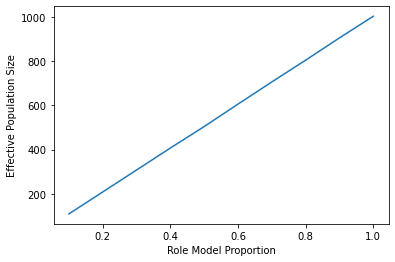

In [77]:
#2B
plt.plot(rms, avg_all_ne)
plt.xlabel("Role Model Proportion")
plt.ylabel("Effective Population Size")

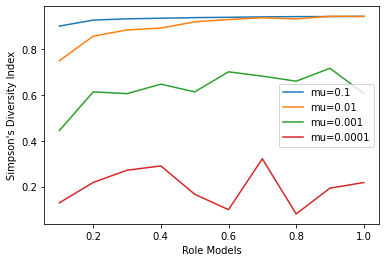

In [78]:
#2C
fig,ax = plt.subplots()

line1 = ax.plot(rms, sdi_0_1, label="mu=0.1")
line2 = ax.plot(rms, sdi_0_01, label="mu=0.01")
line3 = ax.plot(rms, sdi_0_001, label = "mu=0.001")
line4 = ax.plot(rms, sdi_0_0001, label = "mu=0.0001")
ax.set_xlabel("Role Models")
ax.set_ylabel("Simpson's Diversity Index")

ax.legend()

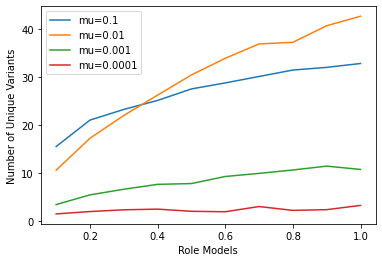

In [80]:
#2D
fig,ax = plt.subplots()

line1 = ax.plot(rms, vars_0_1, label="mu=0.1")
line2 = ax.plot(rms, vars_0_01, label="mu=0.01")
line3 = ax.plot(rms, vars_0_001, label = "mu=0.001")
line4 = ax.plot(rms, vars_0_0001, label = "mu=0.0001")
ax.set_xlabel("Role Models")
ax.set_ylabel("Number of Unique Variants")

ax.legend()

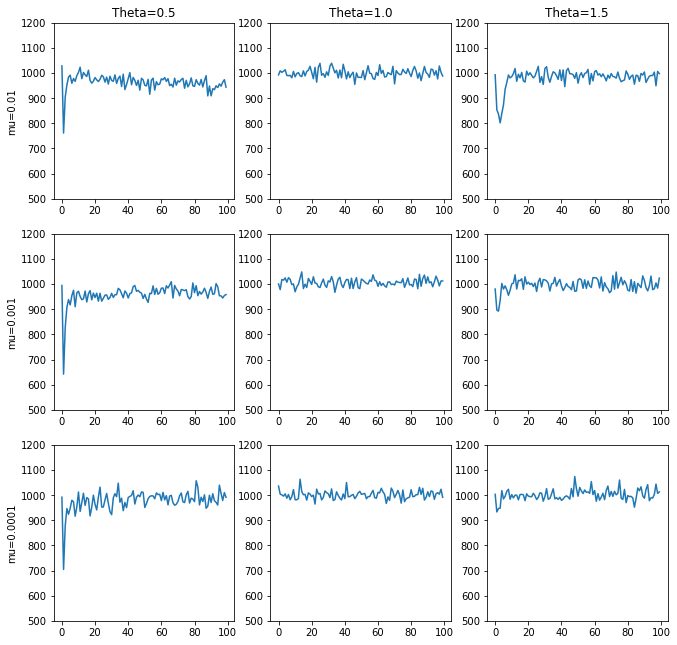

In [128]:
#3

cols = ["Theta=0.5", "Theta=1.0", "Theta=1.5"]
rows = ["mu=0.01", "mu=0.001", "mu=0.0001"]

fig,ax = plt.subplots(3,3,figsize=(11,11))

ax[0,0].plot(gens,anti_0_01)
ax[0,0].set_ylim(500,1200)

ax[1,0].plot(gens,anti_0_001)
ax[1,0].set_ylim(500,1200)

ax[2,0].plot(gens,anti_0_0001)
ax[2,0].set_ylim(500,1200)

ax[0,1].plot(gens,unbiased_0_01)
ax[0,1].set_ylim(500,1200)

ax[1,1].plot(gens,unbiased_0_001)
ax[1,1].set_ylim(500,1200)

ax[2,1].plot(gens,unbiased_0_0001)
ax[2,1].set_ylim(500,1200)

ax[0,2].plot(gens,conform_0_01)
ax[0,2].set_ylim(500,1200)

ax[1,2].plot(gens,conform_0_001)
ax[1,2].set_ylim(500,1200)

ax[2,2].plot(gens,conform_0_0001)
ax[2,2].set_ylim(500,1200)

for a,col in zip(ax[0],cols):
    a.set_title(col)

    for a,row in zip(ax[:,0], rows):
        a.set_ylabel(row)